## Preliminaries

In [1]:
!rm -rf *.sh

<br>

### Packages

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/exhypotheses/beans/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

### Paths

In [4]:
import os
import pathlib
import sys

In [5]:
if not 'google.colab' in str(get_ipython()):    
    notebooks = os.getcwd()
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)
else:
    notebooks = os.getcwd()
    parent = notebooks

<br>

Hence

In [6]:
warehouse = os.path.join(parent, 'warehouse', 'projections')
if not os.path.exists(warehouse):
    os.makedirs(warehouse)

<br>

### Libraries

In [7]:
import logging
import collections

import os

import yellowbrick.cluster

import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.utils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<br>

### Logging

In [8]:
logging.basicConfig(level=logging.INFO, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>

### Custom

In [9]:
import config

import beans.graphics.relational
import beans.graphics.settings

import beans.functions.scale

import beans.src.modelling

<br>

Configurations

In [10]:
configurations = config.Config()

<br>

Graphs

In [11]:
relational = beans.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [12]:
settings = beans.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

Constants

In [13]:
np.random.seed(seed=configurations.SEED)

<br>
<br>

## Data

### Read

In [14]:
modelling = beans.src.modelling.Modelling()

In [15]:
data_, weights_ = modelling.data()
labels = modelling.labels
target = modelling.target

logger.info('Target field: {}'.format(target))
logger.info('\nLabels: {}'.format(labels))


Target field: class
2021-06-16 11:38:39.054

Labels: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
2021-06-16 11:38:39.058


<br>
<br>

## Observations

In [16]:
x_data = data_.drop(columns=target)
y_data = data_[target]

<br>

### Scaling

In [17]:
scale = beans.functions.scale.Scale()
scaler = scale.exc(blob=x_data)

x_scaled = scale.apply(blob=x_data, scaler=scaler)

scaled = pd.concat((x_scaled, y_data), axis=1, ignore_index=False)

<br>

### Elbow

Algorithm

In [18]:
kmc = sklearn.cluster.KMeans(random_state=configurations.SEED, max_iter=1000, algorithm='full')

<br>

Observations

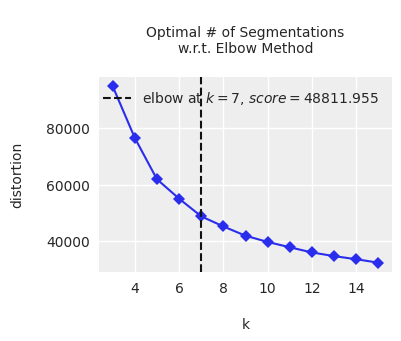

In [19]:
# Fit & Illustrate
ax = relational.figure(width=3.9, height=3.3)
ybc = yellowbrick.cluster.KElbowVisualizer(
    estimator=kmc, k=(3, 16), metric='distortion', timings=False, show=False, ax=ax);
ybc.fit(X=scaled.drop(columns=target))
relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nOptimal # of Segmentations\nw.r.t. Elbow Method\n', 
                                                        '\nk', 'distortion\n']))
ax.legend(loc='upper right', fontsize='small');


In [20]:
elbow = pd.DataFrame(data={'k': ybc.k_values_, 'distortion': ybc.k_scores_})
elbow.loc[:, 'elbow_point'] = (elbow['k'] == ybc.elbow_value_).astype(np.int)

logger.info(elbow.info())

NumExpr defaulting to 2 threads.
2021-06-16 11:38:53.868
None
2021-06-16 11:38:53.885


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   k            13 non-null     int64  
 1   distortion   13 non-null     float64
 2   elbow_point  13 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 440.0 bytes


In [21]:
elbow.to_csv(path_or_buf=os.path.join(warehouse, 'elbow.csv'), 
             index=False, header=True, encoding='utf-8')

<br>
<br>

## Projecting

<br>
<br>

### PCA

Algorithm

In [22]:
kpca_ = sklearn.decomposition.KernelPCA(kernel='cosine')

In [23]:
kpca = kpca_.fit(X=scaled.drop(columns=target))
principals = kpca.transform(scaled.drop(columns=target))

<br>

Projections

In [24]:
names = ['pca_' + str(i).zfill(2) for i in range(1, 1 + principals.shape[1])]
space = pd.concat((pd.DataFrame(data=principals, columns=names), scaled[target]), axis=1)
logger.info('\nMatrix Shape: {}, # of non-zero eigenvalues: {}'\
            .format(scaled.drop(columns=target).shape, kpca.lambdas_.shape[0]))


Matrix Shape: (13611, 16), # of non-zero eigenvalues: 16
2021-06-16 11:50:01.134


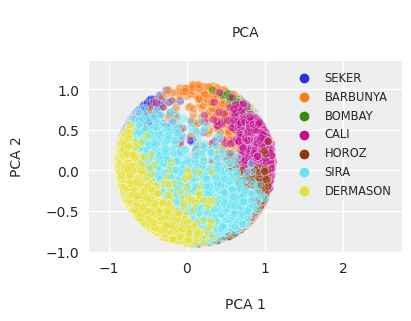

In [25]:
ax = relational.figure(width=4.0, height=3.1)
sns.scatterplot(data=space, x='pca_01', y='pca_02', hue=target, alpha=0.45, ax=ax)

ax.set(xlim=(-1.25, 2.75), ylim=(-1.0, 1.35))

relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nPCA\n', '\nPCA 1', 'PCA 2\n']))
ax.legend(loc='upper right', fontsize='x-small');


In [26]:
space.to_csv(path_or_buf=os.path.join(warehouse, 'PCA.csv'), 
                   index=False, header=True, encoding='utf-8')

In [27]:
kpca.lambdas_

array([6.96663082e+03, 2.96526045e+03, 1.43471111e+03, 1.08621598e+03,
       4.97762598e+02, 1.82024775e+02, 1.26326183e+02, 4.87558833e+01,
       5.51343165e+00, 8.99387374e-01, 7.19612244e-01, 2.04893039e-01,
       7.17480740e-02, 2.87790195e-03, 1.35381554e-03, 8.81177273e-04])

### t-SNE


* `ax.set_xticks(ticks=[-150, -100, -50, 0, 50, 100])`

Algorithm

In [ ]:
sne = sklearn.manifold.TSNE(
    n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, 
    n_iter=1000, n_iter_without_progress=500, random_state=configurations.SEED, method='exact'
)

In [ ]:
transformation = sne.fit_transform(X=scaled.drop(columns=target))

<br>

Projections


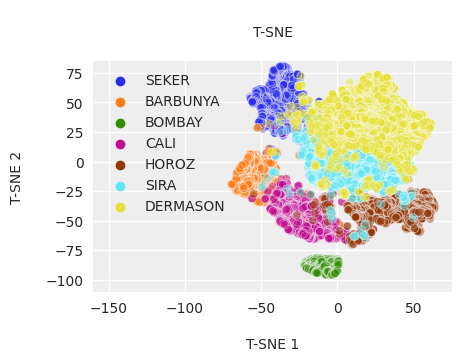

In [ ]:
projections = pd.concat((pd.DataFrame(data=transformation, columns=['tsne_1', 'tsne_2']), scaled[target]), axis=1)

ax = relational.figure(width=4.5, height=3.5)
sns.scatterplot(data=projections, x='tsne_1', y='tsne_2', hue=target, alpha=0.45, ax=ax)

ax.set(xlim=(-160, 75), ylim=(-110, 85))

relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nT-SNE\n', 
                                                        '\nT-SNE 1', 'T-SNE 2\n']))
ax.legend(loc='upper left', fontsize='small'); 
    

In [ ]:
projections.to_csv(path_or_buf=os.path.join(warehouse, 'tSNE.csv'), 
                   index=False, header=True, encoding='utf-8')